# FI-2021 dataset temporal shift error  
This code is for demonstration of temporal shift error in FI-2010 dataset.

### Original source  
https://github.com/LeonardoBerti00/TABL-Temporal-Attention-Augmented-Bilinear-Network-for-Financial-Time-Series-Data-Analysis

### **BiN-TABL**

In [2]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### **Data**
The dataset in the folder Dataset is the FI-2010 dataset zipped and normalized. 

As in the original paper I used the firs 7 days to train and to validate, and the rest 3 days to do the the testing. 

In [3]:
# please change the data_path to your local path and download the files you need from the web site of the dataset

#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Training/Train_Dst_Auction_ZScore_CF_7.txt')
#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Training/Train_Dst_Auction_ZScore_CF_7.txt')
dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Training/Train_Dst_Auction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

#dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
#dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
#dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
#dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_7.txt')
#dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_8.txt')
#dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_9.txt')
dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

# dec_train.shape = (149, 203800)

h = 2        #if h = 2, than horizon = 50
T = 50      #horizon 
dim = 10
k = T//10    #horizon as temporal unit

y_train = dec_train[-h, :].flatten()
# y_train.shape = (203800,)
y_val = dec_val[-h, :].flatten()
y_test = dec_test[-h, :].flatten()

# 10-1: 10 means the length of inputs
# second -1 means [1,2,3] to [0,1,2] conversion of class id
#y_train = y_train[dim-1+(k-1):] - 1
y_train = y_train[dim-1:] - 1
# y_train.shape = (203791,) # 203791 = 203800-(10+1)
#y_val = y_val[dim-1+(k-1):] - 1
y_val = y_val[dim-1:] - 1
#y_test = y_test[dim-1+(k-1):] - 1 
y_test = y_test[dim-1:] - 1 

# First 40 features = 10*4 features
dec_train = dec_train[:40, :].T
# dec_train.shape = (203800, 40)
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

In [4]:
#computing the weights for the weighted cross entropy loss
def compute_weights(y):
  cont_0 = 0
  cont_1 = 0
  cont_2 = 0
  for i in range(y.shape[0]):
    if (y[i] == 0):
      cont_0 += 1
    elif (y[i] == 1):
      cont_1 += 1
    elif (y[i] == 2):
      cont_2 += 2
    else: 
      raise Exception("wrong labels")
  return torch.Tensor([1e6/cont_0, 1e6/cont_1, 1e6/cont_2]).to(device)

y_total = np.concatenate((y_train, y_val, y_test))
weights = compute_weights(y_total)

In [5]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        self.length = x.shape[0] - (T/10) -self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return int(self.length)

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 2, 0)
        input = torch.squeeze(input)

        return input, self.y[i]

In [6]:
#Hyperparameters
batch_size = 256
epochs = 200
   
lr = 0.01
num_classes = 3
dim = 10

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

60577.0
155160.0
242346.0


### **Model Architecture**


In [7]:

class Self_inference(nn.Module):
    # d2=60, d1=40, t1=10, t2=10, d3=120, t3=5, d4=3, t4=1
    def __init__(self, d2, d1, t1, t2, d3, t3, d4, t4):
        super().__init__()

    def forward(self, x):
       
        # x.shape = (32, 40, 10)

        thres = 0.00002
        m_i = (x[:, 0, -1-(k-1)]+x[:, 2, -1-(k-1)])/2.
        m_j = torch.mean((x[:, 0, -(k-1):]+x[:, 2, -(k-1):])/2., dim=1)
        l_j = (m_j - m_i)/m_i

        y = torch.zeros((x.shape[0], 3), device=device)
        
        y[:, 0] = (l_j >= thres)
        y[:, 2] = (l_j <= -thres)
        y[:, 1] = 1.0 - (y[:, 0] + y[:, 2])

        return y


### **Model Training**

I implemented the second setting of the experiment

In [8]:
#Choose between B(TABL) and C(TABL)

#model = BTABL(120, 40, 10, 5, 3, 1)
#model = CTABL(60, 40, 10, 10, 120, 5, 3, 1)
#model = BiN_CTABL(60, 40, 10, 10, 120, 5, 3, 1)
model = Self_inference(60, 40, 10, 10, 120, 5, 3, 1)

model.to(device)

Self_inference()

### **Model Testing**

In [11]:
#model = torch.load('./best_model_CTABL')

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for i, (inputs, targets) in enumerate(test_loader):
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

Test acc: 0.9017


accuracy_score: 0.9016885795308069
              precision    recall  f1-score   support

           0     0.9556    0.8377    0.8928     42518
           1     0.8549    0.9737    0.9105     73154
           2     0.9562    0.8372    0.8927     39488

    accuracy                         0.9017    155160
   macro avg     0.9223    0.8829    0.8987    155160
weighted avg     0.9083    0.9017    0.9011    155160



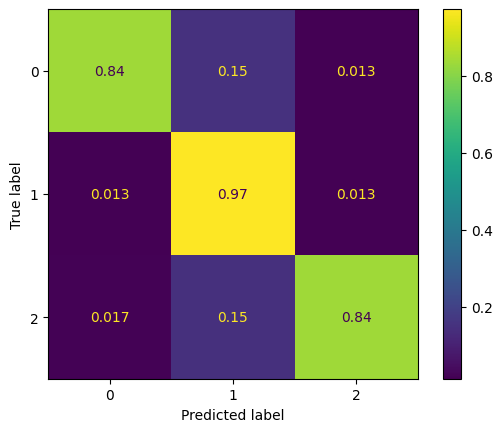

In [12]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()